# Case study: Optimization for volumetric productivity with yield constraint (Klamt2018)

Paper: When do two‐stage processes outperform one‐stage processes? (Klamt *et al.* 2018)

Doi: https://doi.org/10.1002/biot.201700539

In the following code a lactate producing strain was tested with atp-wasting and without (wildtype). We reproduce the results of the paper here showing that with a **minimum yield of 1.662 mmol/mmol** the volumetric productivity of the one-stage fermentation (OSF) (**Vol_P = 1.23 mmol/L/h**) outperforms the volumetric productivity of the two-stage fermentation (TSF) (**Vol_P = 1.06 mmol/L/h**).

In [1]:
### Import packages
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from IPython.display import display

# For storing DataFrames
import pickle

# Get OptMSP
import sys
from os import getcwd
sys.path.append(getcwd())
import MultiStagePackage.OptMSPfunctions as msp

# For optimization
from pygmo import *

### Models

In [2]:
# Read out parameters
auxstates = pd.read_csv("./MultiStagePackage/auxstates.csv", sep=";")

# Index after parameter names
auxstates = auxstates.set_index('Name')
auxstates = auxstates[5:] # only take TSF parameters

# Count parameters for each .csv parameter set
numStates = 3
numAux = len(auxstates)

# Define indices for variables
X_TSF, S_TSF, P_TSF = (i for i in range(numStates))
mue_TSF, r_S_TSF, r_P_TSF, q_S_TSF, q_P_TSF = (i for i in range(numAux))


# inital conditions
s = [0.01, 10.0, 0.0]
# support variables
aux = (auxstates.value).to_numpy()

#### OSF

In [3]:
def growth_phase_wildtype(t,y,aux):
    ## Check for values smaller 0
    for i in range(len(y)):
        if(y[i]<0.0):
            y[i] = 0.0
    gphase=1
    Y_XS=0.022
    Y_PX=69.3
    Y_ATPS=2	
    Y_PATP=1	
    m_ATP=7.7
    v_P=0	
    Y_PS=2
    r_Smax=13.3
    
    if(y[S_TSF]>0.001):
        aux[mue_TSF] = Y_XS*(r_Smax-m_ATP/Y_ATPS-v_P/Y_PS)
        aux[r_S_TSF] = aux[mue_TSF]/Y_XS+m_ATP/Y_ATPS+v_P/Y_PS
        aux[r_P_TSF] = v_P+Y_PATP*m_ATP+Y_PX*aux[mue_TSF]  
    else:
        aux[mue_TSF] = 0.0
        aux[r_S_TSF] = 0.0
        aux[r_P_TSF] = 0.0
    
    aux[q_S_TSF] = aux[r_S_TSF]*y[X_TSF]
    aux[q_P_TSF] = aux[r_P_TSF]*y[X_TSF]

    dXdt =   aux[mue_TSF]*y[X_TSF]
    dSdt = - aux[q_S_TSF]
    dPdt =   aux[q_P_TSF]

    
    dydt = [dXdt, dSdt, dPdt]
    return(dydt)

#### TSF

In [4]:
def growth_phase(t,y,aux):
    ## Check for values smaller 0
    for i in range(len(y)):
        if(y[i]<0.0):
            y[i] = 0.0

    Y_XS_1=0.098	
    Y_PX_1=0	
    Y_ATPS_1=23.5	 
    Y_PATP_1=0
    m_ATP_1=7.7
    r_Smax_1=10	
    v_P_1=0
    Y_PS_1=2	
    if(y[S_TSF]>0.0001):
        aux[mue_TSF] = Y_XS_1*(r_Smax_1-m_ATP_1/Y_ATPS_1-v_P_1/Y_PS_1)
        aux[r_S_TSF] = aux[mue_TSF]/Y_XS_1+m_ATP_1/Y_ATPS_1+v_P_1/Y_PS_1
        aux[r_P_TSF] = v_P_1+Y_PATP_1*m_ATP_1+Y_PX_1*aux[mue_TSF]  
    else:
        aux[mue_TSF] = 0.0
        aux[r_S_TSF] = 0.0
        aux[r_P_TSF] = 0.0
    
    aux[q_S_TSF] = aux[r_S_TSF]*y[X_TSF]
    aux[q_P_TSF] = aux[r_P_TSF]*y[X_TSF]

    dXdt =   aux[mue_TSF]*y[X_TSF]
    dSdt = - aux[q_S_TSF]
    dPdt =   aux[q_P_TSF]

    dydt = [dXdt, dSdt, dPdt]
    return(dydt)


def production_phase(t,y,aux):
    ## Check for values smaller 0
    for i in range(len(y)):
        if(y[i]<0.0):
            y[i] = 0.0
            
    Y_ATPS_2=2
    Y_PATP_2=1
    m_ATP_2=7.7
    v_P_2=0
    Y_PS_2=2
    
    if(y[S_TSF]>0.0001):
        aux[mue_TSF] = 0.0
        aux[r_S_TSF] = m_ATP_2/Y_ATPS_2+v_P_2/Y_PS_2 
        aux[r_P_TSF] = v_P_2+Y_PATP_2*m_ATP_2   
    else:
        aux[mue_TSF] = 0.0
        aux[r_S_TSF] = 0.0
        aux[r_P_TSF] = 0.0
    
    aux[q_S_TSF] = aux[r_S_TSF]*y[X_TSF]    # q_S
    aux[q_P_TSF] = aux[r_P_TSF]*y[X_TSF]    # q_P

    dXdt =   aux[mue_TSF]*y[X_TSF]
    dSdt = - aux[q_S_TSF]
    dPdt =   aux[q_P_TSF]

    dydt = [dXdt, dSdt, dPdt]
    return(dydt)

In [5]:
models = [growth_phase, production_phase]

### Wildtype

Volumetric productivity:   1.2291501953507973
End product:               16.62054429526739


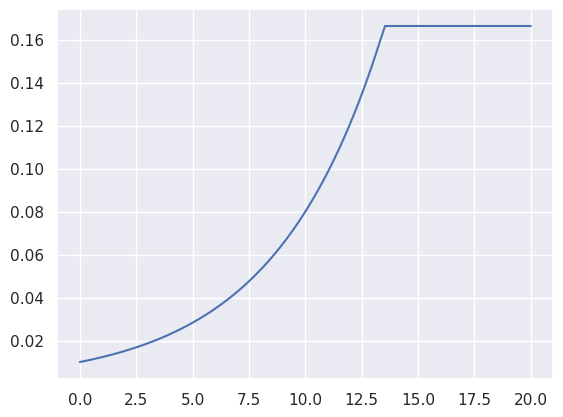

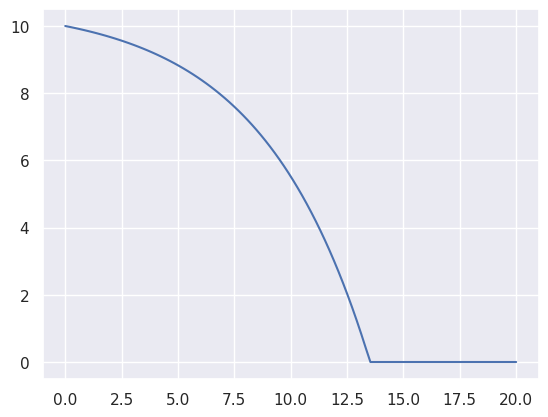

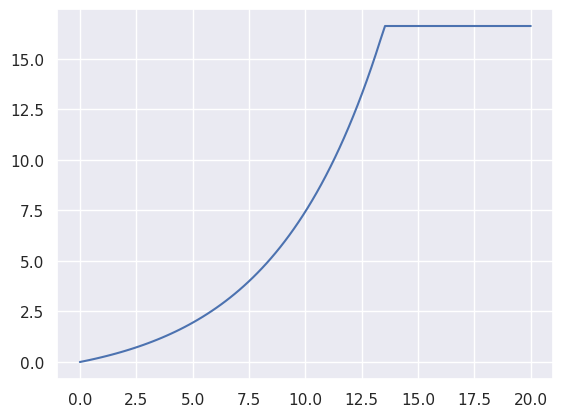

In [6]:
# Define event for finding process end time (when substrate is 0) for vol. prod. calculation
def event_sub0(t,y,aux):
    if(y[S_TSF] <= 0.001):
        return 0    # 0 that event triggers
    return 1

# Set parameters:
aux = (auxstates.value).to_numpy()
t = np.linspace(0,20,100)
res=[]

# Run simulation:
wildtype_sim = sp.integrate.solve_ivp(growth_phase_wildtype, t_span=[0, 20], y0=s, t_eval=[20], events=[event_sub0], args=(aux,), dense_output=True, max_step=0.0001)

# Calculate vol. prod. and print it
res = [wildtype_sim.y_events[0][0][species] for species in range(len(s)) ]
res = res + [wildtype_sim.t_events[0][0]] 

Vol_P=res[P_TSF]/(res[-1])

print("Volumetric productivity:  ", Vol_P)
print("End product:              ", res[P_TSF])

# Plot
plt.plot(t,wildtype_sim.sol(t)[X_TSF],'b-')
plt.show()
plt.plot(t,wildtype_sim.sol(t)[S_TSF],'b-')
plt.show()
plt.plot(t,wildtype_sim.sol(t)[P_TSF],'b-')
plt.show()

### Brute Force Approach

In [6]:
def event_sub0(t,y,aux):
    if(y[S_TSF] <= 0.001):
        return 0    # 0 that event triggers
    return 1

In [10]:
%%time
# Set parameters
aux = (auxstates.value).to_numpy()
t_start = 0
t_end = 20
min_duration = 0
n_stages = 2
den = 100

# Run optimization
BruteForceNum_2Stage = msp.do_brute_force_num(  combis=[(0,1)],                 # We want only one combination of modules (First growth and then production phase)
                                                models=models,                  # The functions of the models 
                                                n_stages=n_stages,              # The maximum stages the user wants to test out (optimal solution might turn out to not have as many stages)
                                                t_start=t_start,                # start time of process
                                                t_end=t_end,                    # end time of process
                                                min_duration=min_duration,      # minimal duration of each sub-process/module
                                                s=s,                            # initial values of species
                                                events=[event_sub0],            # event function for denoting real end time of fermentation (here when no substrate is present anymore; in other use cases different)
                                                density=den,                    # density or step time (how frequent the switching times are sampled -> see for more information OptMSP_SupportFunctions.ipynb notebook)
                                                arguments=(aux,),               # auxiliary variables needed for model (not constant)
                                                indexes=[X_TSF, S_TSF, P_TSF])  # indexes to denote at which position in the model are biomass, substrate and product (default is [0,1,2]; -> see for more information ModelingTutorial.ipynb notebook)

display(BruteForceNum_2Stage)

/home/jbauer/Documents/1_Projects/TwoStg/MultiStagePackage/OptMSPfunctions.py:535: RuntimeWarning: invalid value encountered in scalar divide
  Vol_P=res[indexes[2]]/(res[-2]-t_start)


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 0.0, 20.0)","[1, 2]",0.000,0.000,0.000,0.000,2,NaN,0.000,0.000
1,2,"(0.0, 0.01, 20.0)","[1, 2]",20.000,0.010,9.222,1.554,inf,0.078,0.155,1.997
2,3,"(0.0, 0.02, 20.0)","[1, 2]",20.000,0.010,9.214,1.568,inf,0.078,0.157,1.995
3,4,"(0.0, 0.03, 20.0)","[1, 2]",20.000,0.010,9.206,1.582,inf,0.079,0.158,1.992
4,5,"(0.0, 0.04, 20.0)","[1, 2]",20.000,0.010,9.198,1.596,inf,0.080,0.160,1.990
...,...,...,...,...,...,...,...,...,...,...,...
478,479,"(0.0, 4.78, 20.0)","[1, 2]",4.867,0.928,0.001,0.620,2,0.127,0.062,0.062
479,480,"(0.0, 4.79, 20.0)","[1, 2]",4.850,0.937,0.001,0.434,2,0.089,0.043,0.043
480,481,"(0.0, 4.8, 20.0)","[1, 2]",4.834,0.946,0.000,0.246,2,0.051,0.025,0.025
481,482,"(0.0, 4.8100000000000005, 20.0)","[1, 2]",4.818,0.955,0.000,0.056,2,0.012,0.006,0.006


CPU times: user 51.4 s, sys: 63 µs, total: 51.4 s
Wall time: 51.4 s


In [9]:
# Filter for the minimum yield requirement:
filtered_df = BruteForceNum_2Stage[ BruteForceNum_2Stage['Y_SubUsed'] >= 1.662]  
filtered_df = filtered_df.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0)[:1]
display(filtered_df)

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
299,300,"(0.0, 2.99, 20.0)","[1, 2]",15.674,0.17,0.001,16.619,2,1.06,1.662,1.662


#### Plotting

<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

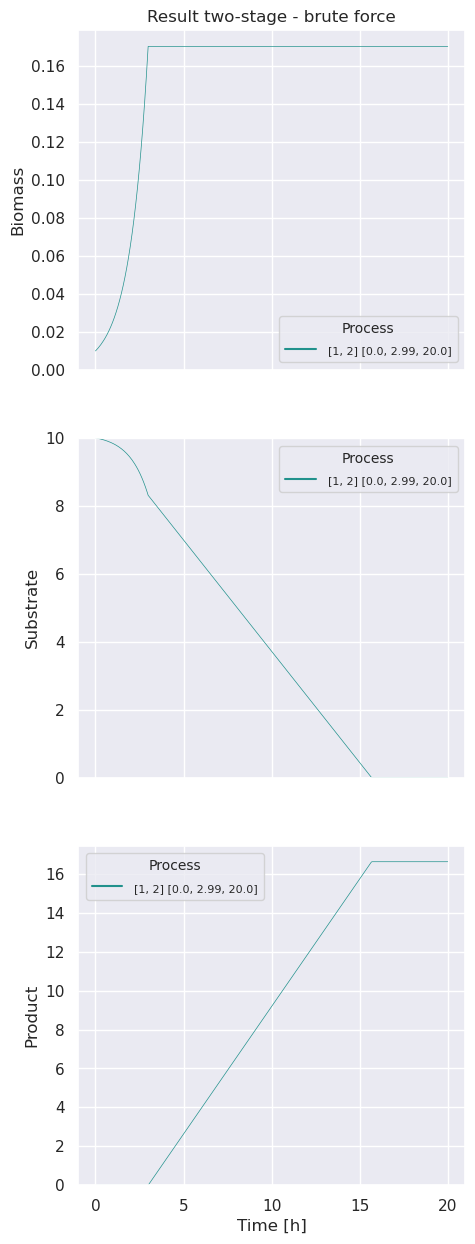

In [18]:
aux = (auxstates.value).to_numpy() # Reset the auxiliary variable to default starting values
msp.do_custom_plot( df=filtered_df, 
                    models_num=models, 
                    s=s, 
                    title="Result two-stage - brute force", 
                    events=[event_sub0], 
                    arguments=(aux,), 
                    indexes=[X_TSF, S_TSF, P_TSF])

### Optimization Approach

#### Optimization approach with product as constraint

because the input substrate is 10 mmol we can also optimize by end product (16.62 mmol)

In [11]:
def event_sub0(t,y,aux):
    if(y[S_TSF] <= 0.001):
        return 0    # 0 that event triggers
    return 1

## 1.) Define objective (here volumetric productivity)
def volprod(simulation, indexes, initial_values, tstart, tend):
    # return simulation[indexes[2]]/(initial_values[indexes[1]]-simulation[indexes[1]])
    return simulation[P_TSF]/(simulation[-2]-tstart)

## Optional: Define constraint (here end product)
def constraint_product(simulation, indexes, initial_values, tstart, tend):
    return simulation[P_TSF]

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=900, seed=12345))  
algo_ihs.set_verbosity(50)  # output best performing each x-th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
problem_sim_volP_1 = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,                                # initial values of species
            models=models,                      # The functions of the models 
            indexes=[X_TSF, S_TSF, P_TSF],      # indexes to denote at which position in the model are biomass, substrate and product (default is [0,1,2]; -> see for more information ModelingTutorial.ipynb notebook)
            tstart=0,                           # start time of process
            tend=20,                            # end time of process
            max_stage=2,                        # The maximum stages the user wants to test out (optimal solution might turn out to not have as many stages)
            min_duration=1,                     # minimal duration of each sub-process/module
            arguments=(aux,),                   # auxiliary variables needed for model (not constant)
            events=[event_sub0],                # event function for denoting real end time of fermentation (here when no substrate is present anymore; in other use cases different)
            objective=volprod,                # Objective function (input as list!!)
            optmod="max",                       # Maximization or minimization? ("max" or "min")
            extracon=[constraint_product],      # Constraints function(s) (input as list!!)
            extracon_vals=[16.62],              # The values for the corresponding constraints provided in extracon (input as list!!)
            extracon_optmod=["greater_than"]    # The denotion if extracon_vals is greater or lower than the constraint value (here it means therefore: end product > 16.62) use "greater_than" or "lower_than"
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance
problem_sim_volP_1.c_tol = 1e-3

## 4.) Starting the optimization
aux = (auxstates.value).to_numpy() # Reset the auxiliary variable to default starting values
res_opt_1 = algo_ihs.evolve(population(problem_sim_volP_1, size=10, seed=12345)) 


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350711       0.987289        16.3071       0.357947              1        9.46007      -0.357947
     51       0.386267       0.520795        6.40814        1.44869              1        4.96827       -1.52569
    101       0.421822       0.274719       0.763624        0.35737              1       0.559525       -1.16832
    151       0.457378       0.144914        0.81892       0.552375              1       0.559525       -1.16832
    201       0.492933      0.0764422       0.332376       0.218464              1       0.559525       -1.16832
    251       0.528489      0.0403233       0.351782       0.245348              0              0      -0.922975
    301       0.564044      0.0212705      0.0710353      0.0471373              0              0      -0.922975
    351         0.5996      0.0112202       0.165472       0.113778              0             

In [28]:
log_dataframe_1 = pd.DataFrame(res_opt_1.problem.extract(decorator_problem).dv_log)[1:] 

best_res_opt_1 = msp.do_opt_to_df(  df=log_dataframe_1,     # log dataframe from optimization
                                    n_best=1)               # Number of best performing processes that are returned

aux = (auxstates.value).to_numpy()
df_1=msp.do_convert(opt_res=best_res_opt_1,             # Output from do_opt_to_df()
                    models_num=models,                  # models (in numeric form)
                    t_start=0, 
                    t_end=20, 
                    s=s, 
                    events=[event_sub0], 
                    arguments=(aux,), 
                    indexes=[X_TSF, S_TSF, P_TSF])

Constraints found. Dataframe is filtered first
        Score      Models                  Times               Constraints
226 -0.875837  (0.0, 1.0)  (2.7200877052157826,)     [-0.8104571387072497]
241 -0.869775  (0.0, 1.0)   (2.711408127884879,)     [-0.7755063505885715]
246 -0.885756  (0.0, 1.0)  (2.7351933000526856,)     [-0.7704131172203823]
249 -0.869775  (0.0, 1.0)   (2.711408127884879,)     [-0.7755063505885715]
254 -0.922975  (0.0, 1.0)   (2.791122957417314,)     [-0.6167225962338243]
..        ...         ...                    ...                       ...
854 -1.060031  (0.0, 1.0)  (2.9895876067433087,)  [-0.0005059979389834268]
866 -1.060045  (0.0, 1.0)   (2.989602488956357,)  [-0.0007284520667809602]
872 -1.060256  (0.0, 1.0)   (2.989887791620673,)   [-0.000622588517217082]
882 -1.060045  (0.0, 1.0)   (2.989602488956357,)  [-0.0007284520667809602]
886 -1.060112  (0.0, 1.0)  (2.9896935070112955,)  [-0.0006820125574762415]

[152 rows x 4 columns]


Best result from optimization:

In [29]:
df_1

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 2.99, 20.0]","[1, 2]",15.676,0.17,0.0,16.621,2,1.06,1.662,1.662


##### Plotting

<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

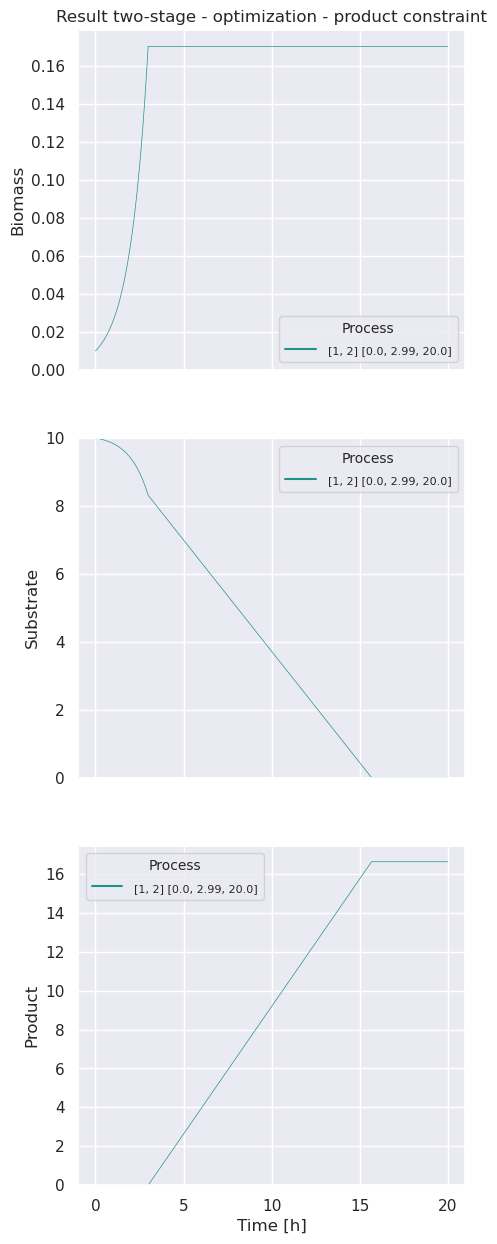

In [30]:
msp.do_custom_plot(df_1, models, s, "Result two-stage - optimization - product constraint", [event_sub0], (aux,))

#### Optimization approach with yield as constraint

In [21]:
def event_sub0(t,y,aux):
    if(y[S_TSF] <= 0.001):
        return 0    # 0 that event triggers
    return 1

## 1.) Define objective (here volumetric productivity)
def volprod(simulation, indexes, initial_values, tstart, tend ):
    # return simulation[indexes[2]]/(initial_values[indexes[1]]-simulation[indexes[1]])
    return simulation[P_TSF]/(simulation[-2]-tstart)

## Optional: Define constraint (here yield)
def constraint_product_yield(simulation, indexes, initial_values, tstart, tend):
    return simulation[P_TSF]/(initial_values[S_TSF]-simulation[S_TSF])

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=900, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(50)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
problem_sim_volP_2 = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,                                # initial values of species
            models=models,                      # The functions of the models 
            indexes=[X_TSF, S_TSF, P_TSF],      # indexes to denote at which position in the model are biomass, substrate and product (default is [0,1,2]; -> see for more information ModelingTutorial.ipynb notebook)
            tstart=0,                           # start time of process
            tend=20,                            # end time of process
            max_stage=2,                        # The maximum stages the user wants to test out (optimal solution might turn out to not have as many stages)
            min_duration=1,                     # minimal duration of each sub-process/module
            arguments=(aux,),                   # auxiliary variables needed for model (not constant)
            events=[event_sub0],                # event function for denoting real end time of fermentation (here when no substrate is present anymore; in other use cases different)
            objective=volprod,                  # Objective function
            optmod="max",                       # Maximization or minimization? ("max" or "min")
            extracon=[constraint_product_yield],# Constraints function(s) (input as list!!)
            extracon_vals=[1.662],              # The values for the corresponding constraints provided in extracon (input as list!!)
            extracon_optmod=["greater_than"]    # The denotion if extracon_vals is greater or lower than the constraint value (here it means therefore: yield > 1.662) use "greater_than" or "lower_than"
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance that 
problem_sim_volP_2.c_tol = 1e-3

## 4.) Starting the optimization
aux = (auxstates.value).to_numpy() # Reset the auxiliary variable to default starting values
res_opt_2 = algo_ihs.evolve(population(problem_sim_volP_2, size=10, seed=12345))  # start with 10 candidate solutions


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350711       0.987289        16.3071       0.357947              0              0      -0.357947
     51       0.386267       0.520795        14.8155       0.280947              0              0      -0.357947
    101       0.421822       0.274719        14.8155       0.280947              0              0      -0.357947
    151       0.457378       0.144914       0.672586       0.294313              0              0       -0.65226
    201       0.492933      0.0764422       0.332376       0.223937              0              0      -0.876197
    251       0.528489      0.0403233       0.113488      0.0835181              0              0      -0.876197
    301       0.564044      0.0212705      0.0766441      0.0509133              0              0       -0.92711
    351         0.5996      0.0112202       0.165472       0.114066              0             

In [31]:
log_dataframe_2 = pd.DataFrame(res_opt_2.problem.extract(decorator_problem).dv_log)[1:] 

best_res_opt_2 = msp.do_opt_to_df(  df=log_dataframe_2,     # log dataframe from optimization
                                    n_best=1)               # Number of best performing processes that are returned

aux = (auxstates.value).to_numpy()
df_2=msp.do_convert(opt_res=best_res_opt_2,             # Output from do_opt_to_df()
                    models_num=models,                  # models (in numeric form)
                    t_start=0, 
                    t_end=20, 
                    s=s, 
                    events=[event_sub0], 
                    arguments=(aux,), 
                    indexes=[X_TSF, S_TSF, P_TSF])

Constraints found. Dataframe is filtered first
        Score      Models                  Times             Constraints
0   -0.357947  (0.0, 1.0)  (1.7156709370460683,)   [-0.1230881770759662]
1   -0.077000  (1.0, 1.0)  (10.577402498158406,)   [-0.3380000000018941]
2   -0.077000  (1.0, 1.0)   (9.314673543758984,)   [-0.3380000000018941]
6   -0.077000  (1.0, 1.0)  (15.531196744036084,)  [-0.33800000000189456]
7   -0.077000  (1.0, 1.0)  (17.342648154258875,)   [-0.3380000000018937]
..        ...         ...                    ...                     ...
893 -0.077000  (1.0, 1.0)  (2.9926855709986144,)  [-0.33800000000189456]
897 -0.077000  (1.0, 1.0)  (2.9929443820182278,)   [-0.3380000000018941]
904 -0.077000  (1.0, 1.0)    (2.99276368554601,)   [-0.3380000000018941]
906 -0.077000  (1.0, 1.0)  (2.9928644172226684,)   [-0.3380000000018897]
908 -0.077000  (1.0, 1.0)  (2.9929450574613554,)  [-0.33800000000189456]

[493 rows x 4 columns]


Best result from optimization:

In [32]:
df_2

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 2.99, 20.0]","[1, 2]",15.677,0.17,0.0,16.621,2,1.06,1.662,1.662


##### Potting

<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

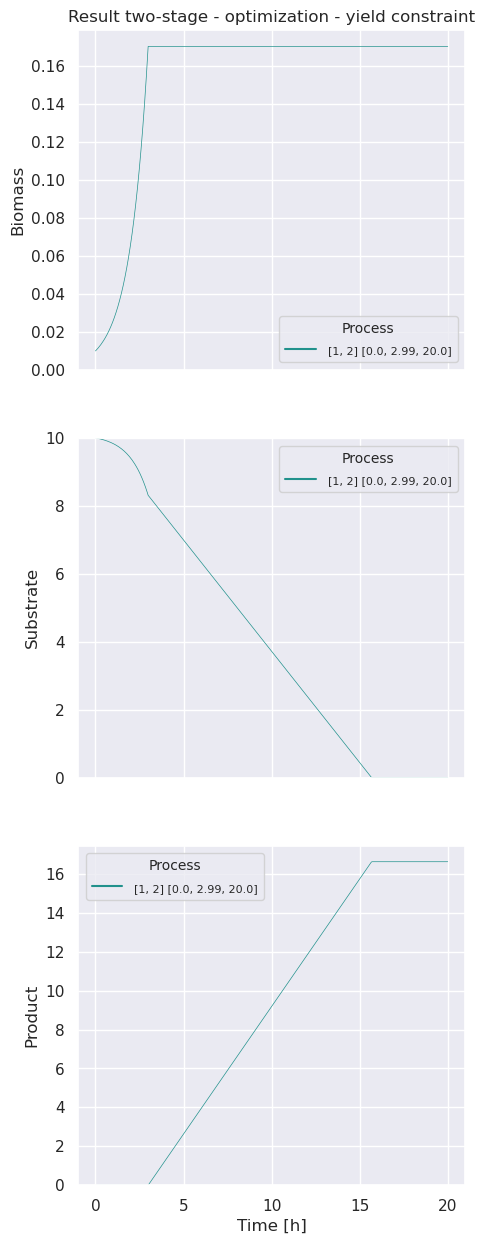

In [33]:
msp.do_custom_plot(df_2, models, s, "Result two-stage - optimization - yield constraint", [event_sub0], (aux,))